In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import mnist # for CNN we want the non-flatten mnist dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

## Utility functions

In [21]:
# plot performances
def model_performance(histories):
    fig = plt.figure(figsize=(15, 5))
    for i in range(len(histories)):
        # plot loss
        plt.subplot(1, 2, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='black')
        plt.plot(histories[i].history['val_loss'], color='red', linestyle='dashed')
        plt.xlabel('Epochs')
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        plt.legend(['train', 'validation'], loc='upper right')
        # plot accuracy
        plt.subplot(1, 2, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='black')
        plt.plot(histories[i].history['val_accuracy'], color='red', linestyle='dashed')
        plt.xlabel('Epochs')
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

In [3]:
# score
def score(model, testX, testY):
    sco = model.evaluate(
        testX,
        to_categorical(testY)
    )
    result = "This model achieved {:.3f} test loss and {:.2f} % test accuracy".format(sco[0], sco[1]*100)
    return result

## Dataset loading and pre-treatment

In [4]:
(trainX, trainY), (testX, testY) = mnist.load_data()

In [5]:
print(trainX.shape) # (60000, 28, 28)
print(trainY.shape) # (60000,)

(60000, 28, 28)
(60000,)


In [6]:
# Normalizing in the interval [-0.5, 0.5]
trainX = (trainX / 255) - 0.5
testX = (testX / 255) - 0.5

In [7]:
# Reshaping the images (keras expects a 3D array)
trainX = np.expand_dims(trainX, axis=3)
testX = np.expand_dims(testX, axis=3)

print(trainX.shape) # (60000, 28, 28, 1)
print(testX.shape)  # (10000, 28, 28, 1)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Models

In [8]:
def define_model_1():
    num_filters = 8
    kernel_size = 3
    pool_size = 2
    model = Sequential([
        Conv2D(num_filters, kernel_size, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.5),
        Flatten(),
        Dense(10, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

In [9]:
print(define_model_1().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# reasonable "best" model ?? https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
def define_best_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=5, padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))


    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

In [11]:
print(define_best_model().summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

## Model evaluation

In [12]:
def evaluate_model(model, dataX, dataY, n_folds=5, epochs=8, verbose=0, batch_size=32):
    histories = list()
    kfold = KFold(n_folds, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(dataX):
        trainX, testX = dataX[train_index], dataX[test_index]
        trainY, testY = dataY[train_index], dataY[test_index]
        # fit model
        history = model.fit(
            trainX,
            to_categorical(trainY),
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(testX, to_categorical(testY)),
            verbose=verbose
        )
        histories.append(history)
    return histories

In [13]:
histories_best_model = evaluate_model(define_best_model(), trainX, trainY, verbose=1, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 103s 68ms/step - loss: 0.5343 - accuracy: 0.8229 - val_loss: 0.0533 - val_accuracy: 0.9843
Epoch 2/10
1500/1500 [==============================] - 108s 72ms/step - loss: 0.0975 - accuracy: 0.9697 - val_loss: 0.0461 - val_accuracy: 0.9864
Epoch 3/10
1500/1500 [==============================] - 116s 77ms/step - loss: 0.0675 - accuracy: 0.9798 - val_loss: 0.0371 - val_accuracy: 0.9895
Epoch 4/10
1500/1500 [==============================] - 110s 73ms/step - loss: 0.0588 - accuracy: 0.9824 - val_loss: 0.0344 - val_accuracy: 0.9907
Epoch 5/10
1500/1500 [==============================] - 105s 70ms/step - loss: 0.0523 - accuracy: 0.9835 - val_loss: 0.0336 - val_accuracy: 0.9909
Epoch 6/10
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.0309 - val_accuracy: 0.9918
Epoch 7/10
1500/1500 [==============================] - 126s 84ms/step - loss: 0.0441 - accuracy: 0.9859 - val_loss: 0

<ipython-input-21-38fd23924c5f>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-21-38fd23924c5f>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


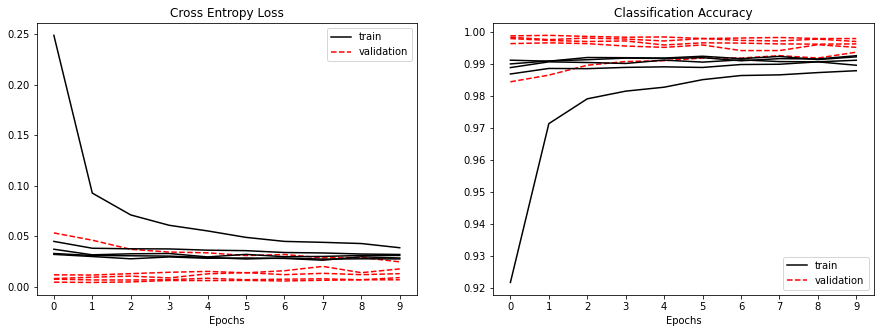

In [22]:
model_performance(histories_best_model)

In [55]:
final_model = define_best_model()

In [56]:
final_model.fit(
    trainX,
    to_categorical(trainY),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1875/1875 [==============================] - 152s 80ms/step - loss: 0.4583 - accuracy: 0.8501
Epoch 2/10
1875/1875 [==============================] - 149s 79ms/step - loss: 0.0890 - accuracy: 0.9725
Epoch 3/10
1875/1875 [==============================] - 142s 76ms/step - loss: 0.0684 - accuracy: 0.9796
Epoch 4/10
1875/1875 [==============================] - 140s 75ms/step - loss: 0.0569 - accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 136s 72ms/step - loss: 0.0474 - accuracy: 0.9860
Epoch 6/10
1875/1875 [==============================] - 146s 78ms/step - loss: 0.0438 - accuracy: 0.9868
Epoch 7/10
1875/1875 [==============================] - 155s 83ms/step - loss: 0.0413 - accuracy: 0.9877
Epoch 8/10
1875/1875 [==============================] - 149s 79ms/step - loss: 0.0417 - accuracy: 0.9873
Epoch 9/10
1875/1875 [==============================] - 139s 74ms/step - loss: 0.0373 - accuracy: 0.9884
Epoch 10/10
1875/1875 [==============================] 

In [68]:
score(final_model, testX, testY)

313/313 [==============================] - 5s 16ms/step - loss: 0.0221 - accuracy: 0.9930


'This model achieved 0.022 test loss and 99.30 % test accuracy'

In [73]:
# Store the predictions
predictions = final_model.predict(testX)
predicted = np.argmax(predictions, axis=1)

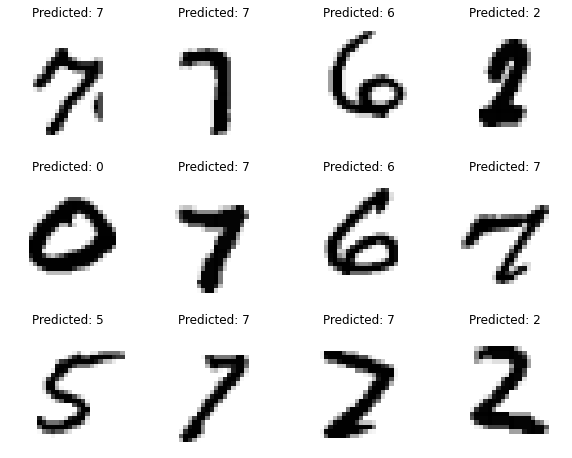

In [74]:
# We randomly pick 12 images
images = testX.reshape((-1, 28, 28))

select = np.random.randint(testX.shape[0], size=12)

fig = plt.figure(figsize=(10,8))
for index, value in enumerate(select):
    fig.add_subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow((images[value]+0.5)*255,cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: {}'.format(predicted[value]))


<AxesSubplot:>

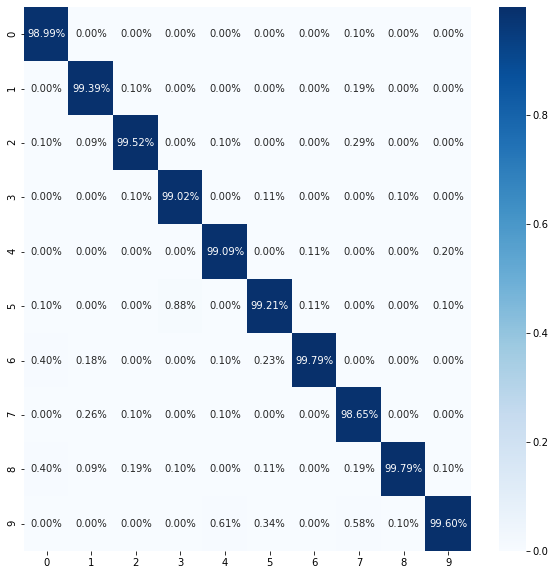

In [75]:
cf_matrix = confusion_matrix(testY, predicted)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix / sum(cf_matrix), fmt = '.2%', annot=True, cmap='Blues')